In [16]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.0.1'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
# Get some names from https://github.com/MASTREX/List-of-Indian-Names

In [6]:
!wget https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv -O names-long.csv

--2024-03-07 11:57:26--  https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85538 (84K) [text/plain]
Saving to: ‘names-long.csv’

names-long.csv      100%[===================>]  83.53K  --.-KB/s    in 0.08s   

2024-03-07 11:57:26 (1.08 MB/s) - ‘names-long.csv’ saved [85538/85538]



In [7]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [8]:
!tail names-long.csv

6476,zeshan
6477,zhini
6478,ziarul
6479,zile
6480,zina
6481,zishan
6482,ziyabul
6483,zoya
6484,zuhaib
6485,zuveb


In [13]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]


['ramniwas',
 'kirpa',
 'shaheen',
 'farjanul',
 'mooldan',
 'jugal',
 'zainab',
 'rehman',
 'lav',
 'girjesh']

In [14]:
len(words)

6184

In [17]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}


In [31]:
block_size = 4 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

.... ---> r
...r ---> a
..ra ---> m
.ram ---> n
ramn ---> i
amni ---> w
mniw ---> a
niwa ---> s
iwas ---> .
.... ---> k
...k ---> i
..ki ---> r
.kir ---> p
kirp ---> a
irpa ---> .
.... ---> s
...s ---> h
..sh ---> a
.sha ---> h
shah ---> e
hahe ---> e
ahee ---> n
heen ---> .
.... ---> f
...f ---> a
..fa ---> r
.far ---> j
farj ---> a
arja ---> n
rjan ---> u
janu ---> l
anul ---> .
.... ---> m
...m ---> o
..mo ---> o
.moo ---> l
mool ---> d
oold ---> a
olda ---> n
ldan ---> .
.... ---> j
...j ---> u
..ju ---> g
.jug ---> a
juga ---> l
ugal ---> .
.... ---> z
...z ---> a
..za ---> i
.zai ---> n
zain ---> a
aina ---> b
inab ---> .
.... ---> r
...r ---> e
..re ---> h
.reh ---> m
rehm ---> a
ehma ---> n
hman ---> .
.... ---> l
...l ---> a
..la ---> v
.lav ---> .
.... ---> g
...g ---> i
..gi ---> r
.gir ---> j
girj ---> e
irje ---> s
rjes ---> h
jesh ---> .
.... ---> v
...v ---> i
..vi ---> c
.vic ---> h
vich ---> i
ichi ---> t
chit ---> r
hitr ---> a
itra ---> .
.... ---> n
...n ---> a
..na

In [32]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 4]), torch.int64, torch.Size([44325]), torch.int64)

In [20]:
# Embedding layer for the context

emb_dim = 2
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [21]:
emb.weight

Parameter containing:
tensor([[-0.3138, -0.1536],
        [-0.3248, -0.2952],
        [-1.1912,  0.5394],
        [-2.1714, -1.7905],
        [ 0.1667,  0.2279],
        [ 0.4955,  1.3448],
        [-1.6937,  0.2885],
        [-1.0793, -0.6114],
        [ 1.1891, -1.2099],
        [ 0.5200,  0.4261],
        [-1.0763, -0.0943],
        [ 0.5206,  1.7179],
        [ 2.2021,  0.2987],
        [ 0.5404, -1.6114],
        [ 0.1399, -1.1261],
        [-0.9631, -0.2187],
        [-0.6454,  0.1002],
        [ 1.4101,  1.3876],
        [-0.5676,  1.1753],
        [-1.2490, -0.2943],
        [ 0.0046, -0.7186],
        [-1.0149,  0.2007],
        [ 0.1595,  1.0203],
        [ 1.7339, -0.7053],
        [-0.4395, -2.3451],
        [-0.3335,  0.9717],
        [ 0.1230,  0.1068]], requires_grad=True)

<Axes: >

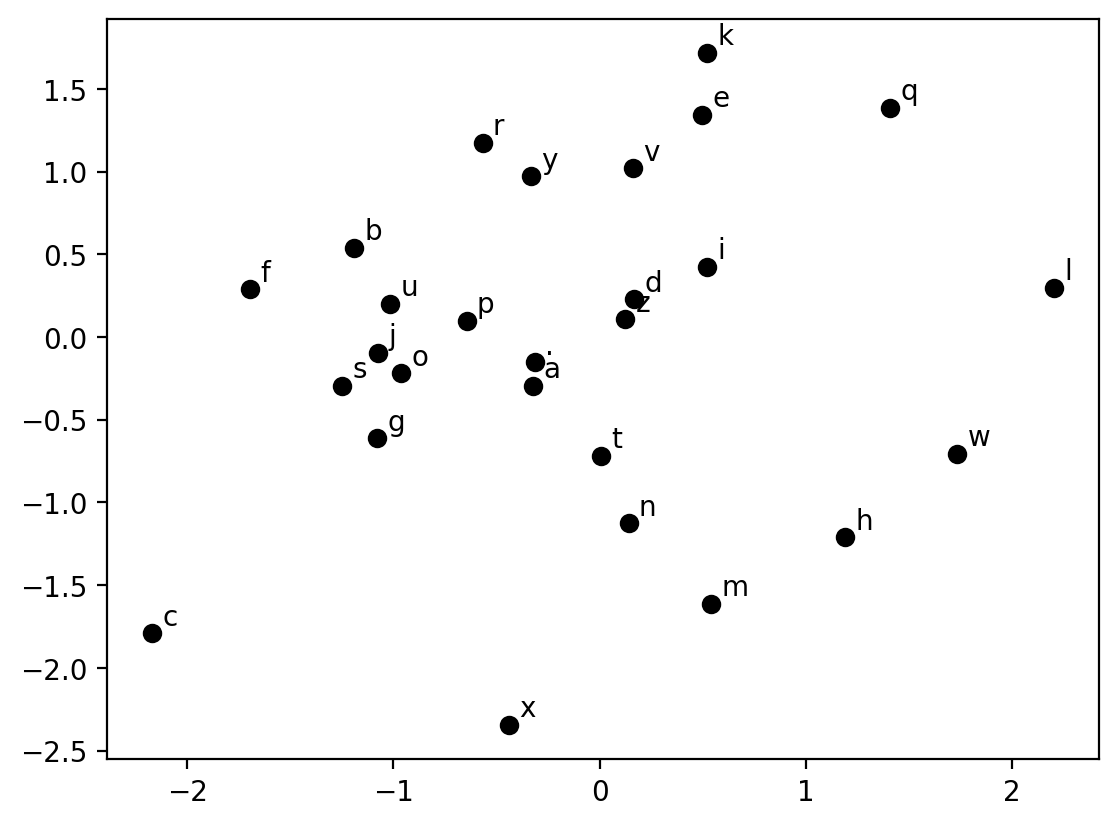

In [33]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb.weight[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

In [34]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x
    

In [45]:
# Generate names from untrained model


model = NextChar(block_size, len(stoi), emb_dim, 10).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

pj
ijenncoxxu
dmyqofnn
cvfwgc
nwsyhanaoo
jstdoejirr
mqsmngniwh
jmbvdoscdp
spihnsmdib
cowituuuzx


In [46]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([27, 2])
_orig_mod.lin1.weight torch.Size([10, 8])
_orig_mod.lin1.bias torch.Size([10])
_orig_mod.lin2.weight torch.Size([27, 10])
_orig_mod.lin2.bias torch.Size([27])


In [47]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(10000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())
        print("Time taken for 1 epochs: {} seconds".format(sum(elapsed_time)/print_every))


0 2.9864540100097656
Time taken for 1 epochs: 0.049516870975494384 seconds
100 2.264863967895508
Time taken for 1 epochs: 0.08144856929779053 seconds
200 2.2548608779907227
Time taken for 1 epochs: 0.11445709228515626 seconds
300 2.2528393268585205
Time taken for 1 epochs: 0.14776105165481568 seconds
400 2.2472333908081055
Time taken for 1 epochs: 0.18110310792922973 seconds
500 2.2465100288391113
Time taken for 1 epochs: 0.22573707580566407 seconds
600 2.246344804763794
Time taken for 1 epochs: 0.2612206554412842 seconds
700 2.2438950538635254
Time taken for 1 epochs: 0.29567924737930296 seconds
800 2.2388381958007812
Time taken for 1 epochs: 0.32983007907867434 seconds
900 2.2368485927581787
Time taken for 1 epochs: 0.3694626259803772 seconds
1000 2.234588861465454
Time taken for 1 epochs: 0.4038619804382324 seconds
1100 2.232642412185669
Time taken for 1 epochs: 0.4363677763938904 seconds
1200 2.23117995262146
Time taken for 1 epochs: 0.4688509774208069 seconds
1300 2.22938752174377

KeyboardInterrupt: 

<Axes: >

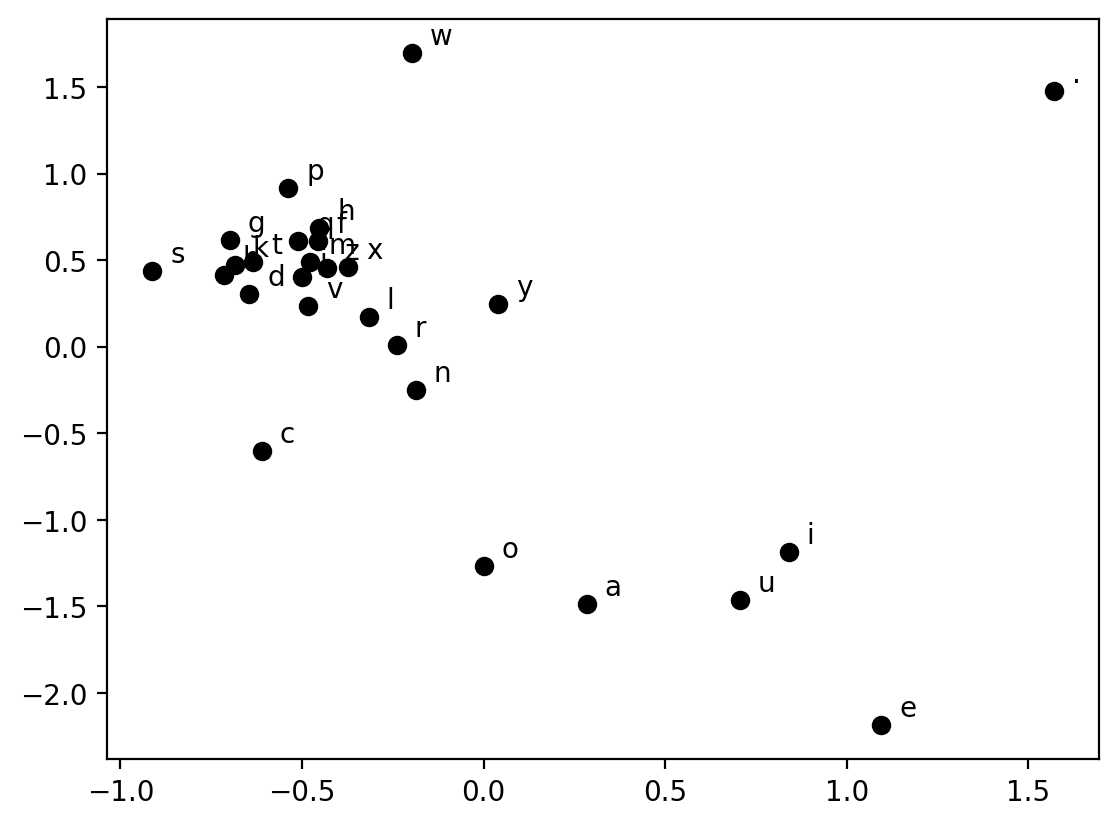

In [48]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [49]:
# Generate names from trained model

for i in range(10):
    print(generate_name(model, itos, stoi, block_size))

chwhula
solin
hribm
mivi
siri
inya
ridha
yamandana
pama
safi


Tuning knobs

1. Embedding size
2. MLP 
3. Context length